In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import norm 

In [2]:
# Convertible bond pricing model (Cox-Ross-Rubinstein method)
def CRR_convertible_bond(S0, F, T, r, k, coupon, CRatio, N, AmeEur='e'):
    # Time step
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))     # Up factor
    d = 1 / u                           # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Create the binomial stock price tree
    stock_price_tree = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            stock_price_tree[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price tree (including coupon payments)
    bond_price_tree = np.zeros((N + 1, N + 1))
    # Create the conversion probability tree
    conversion_prob_tree = np.zeros((N + 1, N + 1))

    # Calculate bond prices and conversion probabilities at maturity
    for j in range(N + 1):
        stock_price = stock_price_tree[j, N]
        bond_value_at_maturity = max(CRatio * stock_price, F + coupon)
        bond_price_tree[j, N] = bond_value_at_maturity
        # Conversion probability is 1 if conversion is optimal at maturity
        conversion_prob_tree[j, N] = 1 if CRatio * stock_price > F + coupon else 0

    # Initialize coupon timing and time management
    CouponTime = T  # Initial coupon time matches maturity

    # Backward calculation for bond price and conversion probability
    for i in range(N - 1, -1, -1):
        if CouponTime != (T - np.ceil((N - i + 1) * dt)):
            CouponPayment = 1  # It's time to pay a coupon
            CouponTime = T - np.ceil((N - i) * dt)
            Time = CouponTime - dt * i
        else:
            CouponPayment = 0

        for j in range(i + 1):
            stock_price = stock_price_tree[j, i]

            # Dynamic discount factors (ru, rd)
            ru = conversion_prob_tree[j+1, i+1] * r + (1 - conversion_prob_tree[j+1, i+1]) * (r + k)
            rd = conversion_prob_tree[j, i+1] * r + (1 - conversion_prob_tree[j, i+1]) * (r + k)

            if CouponPayment == 1:
                CouponValue = coupon * (p * np.exp(-ru * Time) + (1 - p) * np.exp(-rd * Time))
            else:
                CouponValue = 0

            # Calculate bond price using backward induction
            hold_bond_value = CouponValue + p * bond_price_tree[j + 1, i + 1] * np.exp(-ru * dt) + (1 - p) * bond_price_tree[j, i + 1] * np.exp(-rd * dt)
            convert_to_stock_value = CRatio * stock_price

            # Bond price is the maximum of holding or converting
            bond_price_tree[j, i] = max(hold_bond_value, convert_to_stock_value)

            # Conversion probability: set to 1 if conversion happens, otherwise average the next nodes
            if bond_price_tree[j, i] == convert_to_stock_value:
                conversion_prob_tree[j, i] = 1
            else:
                conversion_prob_tree[j, i] = p * conversion_prob_tree[j + 1, i + 1] + (1 - p) * conversion_prob_tree[j, i + 1]

    return stock_price_tree, bond_price_tree, conversion_prob_tree

In [3]:
# Function to plot the binomial tree
def plot_binomial_tree(tree, title):
    N = tree.shape[1] - 1
    G = nx.DiGraph()

    pos = {}
    labels = {}
    
    # Define the horizontal offset to center the nodes at each level
    for i in range(N + 1):
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  # Adjust vertical position to center the tree
            labels[node] = f"{tree[j, i]:.2f}"

            if i < N:
                G.add_edge(node, f"{i+1},{j}")
                G.add_edge(node, f"{i+1},{j+1}")

    # Plot
    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()

In [4]:
# Parameters
S0 = 75                             # Initial stock price
F = 100                             # Face value of the bond
X = 100                             # Strike price for conversion
T = 5                               # Time to maturity (in years)
r = 0.07                            # Risk-free rate
CRatio = F / X                      # Conversion ratio
k = 0.03                            # Credit spread
sigma = 0.2                         # Volatility
dt = 1
coupon = 6                          # Coupon payment per year
m = 1                               # Conversion ratio (1 bond = 1 stock)
N = 5                               # Number of time steps

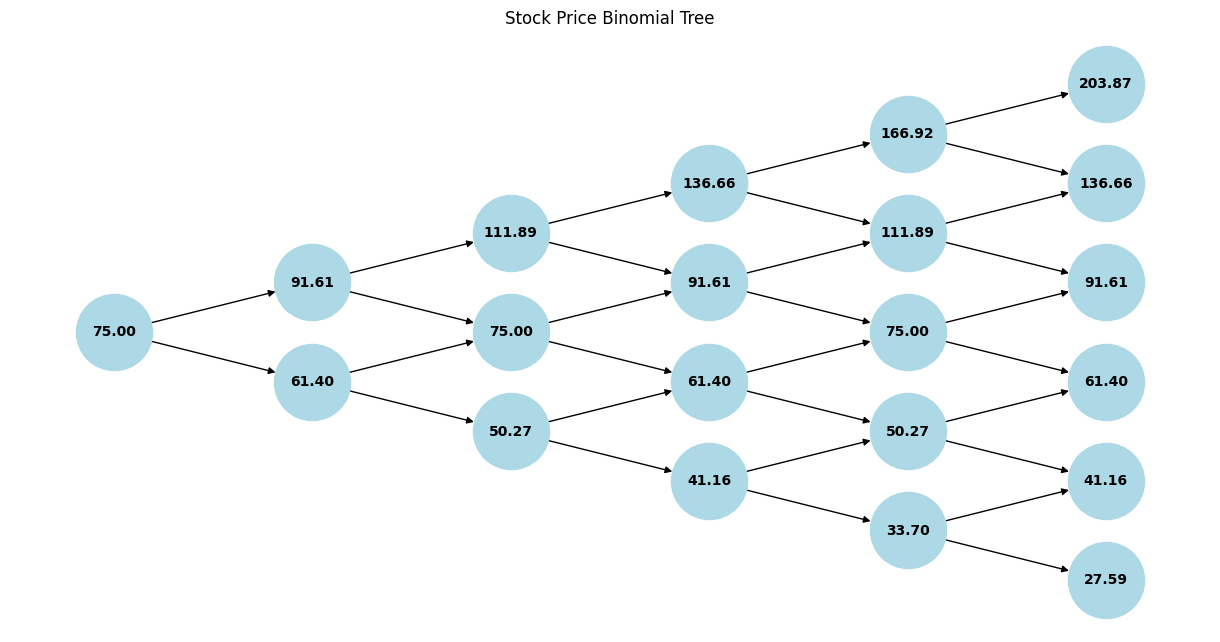

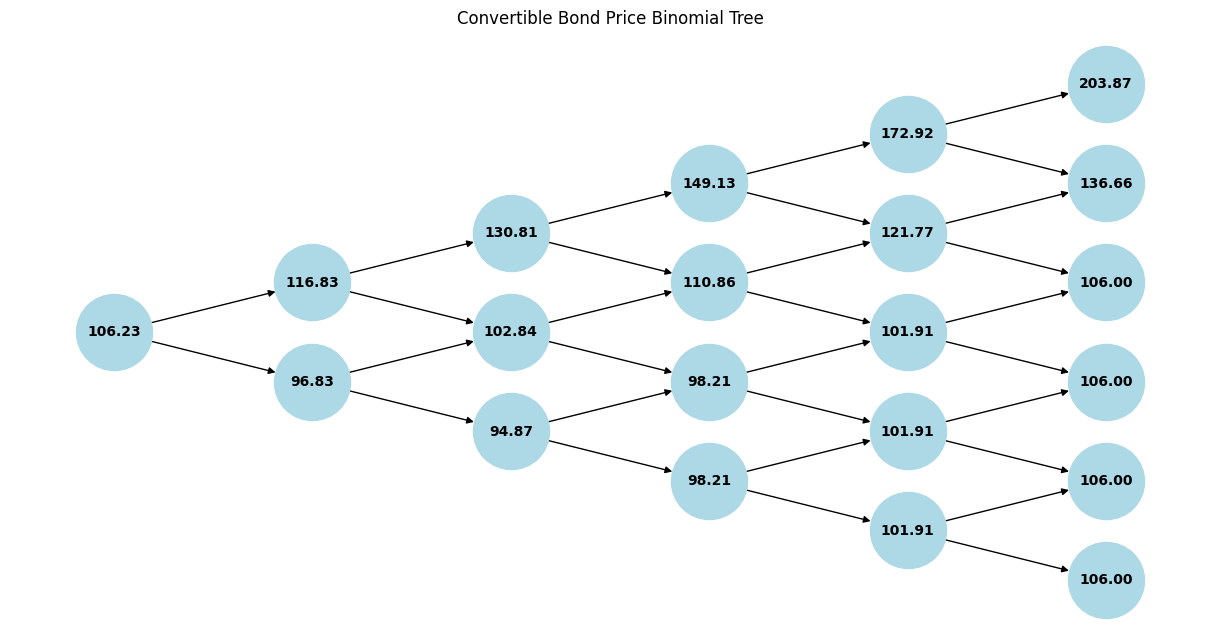

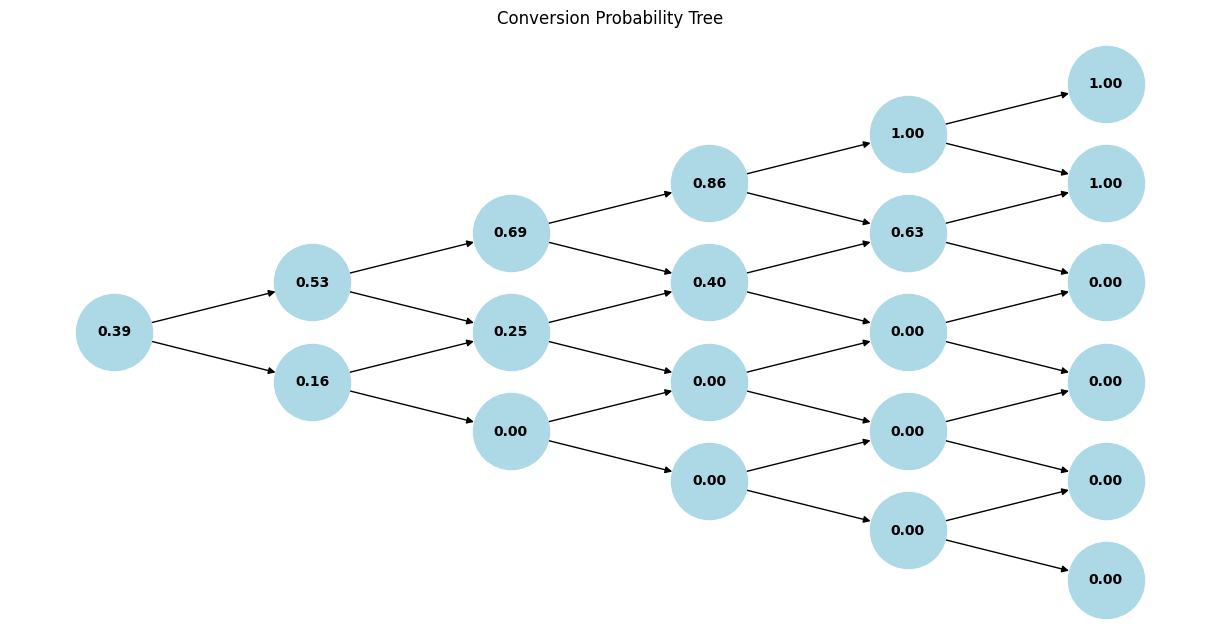

In [5]:
# Calculate the binomial trees
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, N)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")

In [6]:
# Function to calculate tree parameters (u, d, p) for different models
def calculate_tree_parameters(r, q, sigma, dt, model_type, drift=0):
    if model_type == 'CRR':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r - q) * dt) - d) / (u - d)
    elif model_type == 'CRR_Drift':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r - q + drift) * dt) - d) / (u - d)
    elif model_type == 'Jarrow-Rudd':
        u = np.exp((r - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt))
        d = np.exp((r - q - 0.5 * sigma ** 2) * dt - sigma * np.sqrt(dt))
        p = 0.5
    elif model_type == 'Tian':
        a = np.exp((r - q) * dt)
        b = np.exp(sigma * np.sqrt(dt))
        u = 0.5 * a * (b + 1 / b + np.sqrt((b - 1 / b) ** 2 + 4))
        d = a / u
        p = (a - d) / (u - d)
    elif model_type == 'Haahtela':
        b = r - q - 0.5 * sigma**2
        u = np.exp(sigma * np.sqrt(3 * dt))
        d = 1 / u
        p = (np.exp(b * dt) - d) / (u - d)       
    else:
        raise ValueError("Unknown model type provided.")
    
    return u, d, p

In [7]:
# Function to calculate the convertible bond price and conversion probability trees
def calculate_convertible_bond_price_and_probability(S0, F, T, r, k, sigma, q, coupon, CRatio, N, model_type, drift=0):
    dt = T / N
    u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift)

    # Create the binomial stock price tree
    StockPrice = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price and conversion probability trees
    BondPrice = np.zeros((N + 1, N + 1))
    ConversionProbability = np.zeros((N + 1, N + 1))

    # Calculate bond value at maturity
    for i in range(N + 1):
        BondPrice[i, N] = max(F + coupon, CRatio * StockPrice[i, N])
        ConversionProbability[i, N] = 1 if BondPrice[i, N] == CRatio * StockPrice[i, N] else 0

    # Backward calculation for bond price and conversion probability
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            # Calculate the present value of the bond price using risk-neutral probabilities
            BondPrice[i, j] = np.exp(-(r+k) * dt) * (p * BondPrice[i + 1, j + 1] + (1 - p) * BondPrice[i, j + 1])
            
            # Calculate conversion probability as weighted average
            ConversionProbability[i, j] = p * ConversionProbability[i + 1, j + 1] + (1 - p) * ConversionProbability[i, j + 1]

    return StockPrice, BondPrice, ConversionProbability


In [8]:
# Function to plot a binomial tree
def plot_binomial_tree(tree, title):
    N = tree.shape[1] - 1
    G = nx.DiGraph()
    pos = {}
    labels = {}
    
    for i in range(N + 1):
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  # Adjust position to align nodes symmetrically
            labels[node] = f"{tree[j, i]:.2f}"
            if i < N:
                G.add_edge(node, f"{i+1},{j}")
                G.add_edge(node, f"{i+1},{j+1}")

    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()

In [9]:
# Function to create and plot trees for each model
def create_and_plot_trees(S0, F, T, r, k, sigma, q, coupon, CRatio, N, models):
    for model in models:
        print(f"\n=== Model: {model} ===")
        
        u, d, p = calculate_tree_parameters(r, q, sigma, dt, model)
        print(f"u = {u:.4f}, d = {d:.4f}, p = {p:.4f}")
        
        # Calculate stock price, bond price, and conversion probability trees
        StockPrice, BondPrice, ConversionProbability = calculate_convertible_bond_price_and_probability(S0, F, T, r, k, sigma, q, coupon, CRatio, N, model)
        
        # Plot Stock Price Tree
        plot_binomial_tree(StockPrice, f"Stock Price Binomial Tree - {model}")
        
        # Plot Bond Price Tree
        plot_binomial_tree(BondPrice, f"Convertible Bond Price Binomial Tree - {model}")
        
        # Plot Conversion Probability Tree
        plot_binomial_tree(ConversionProbability, f"Conversion Probability Binomial Tree - {model}")


=== Model: CRR ===
u = 1.2214, d = 0.8187, p = 0.6302


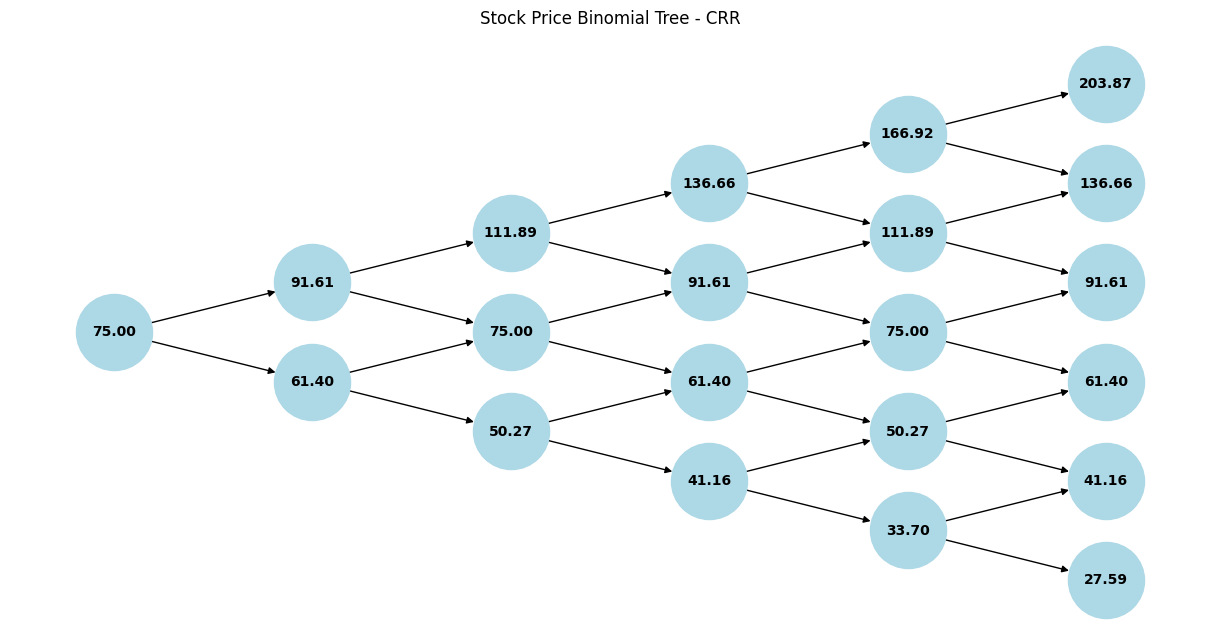

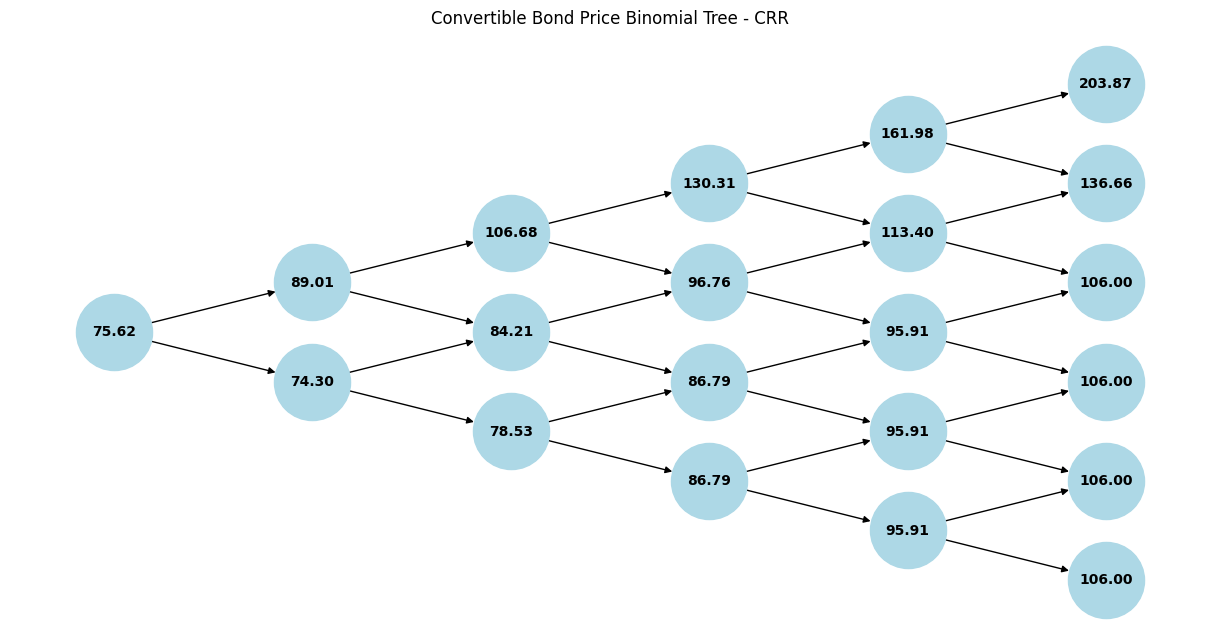

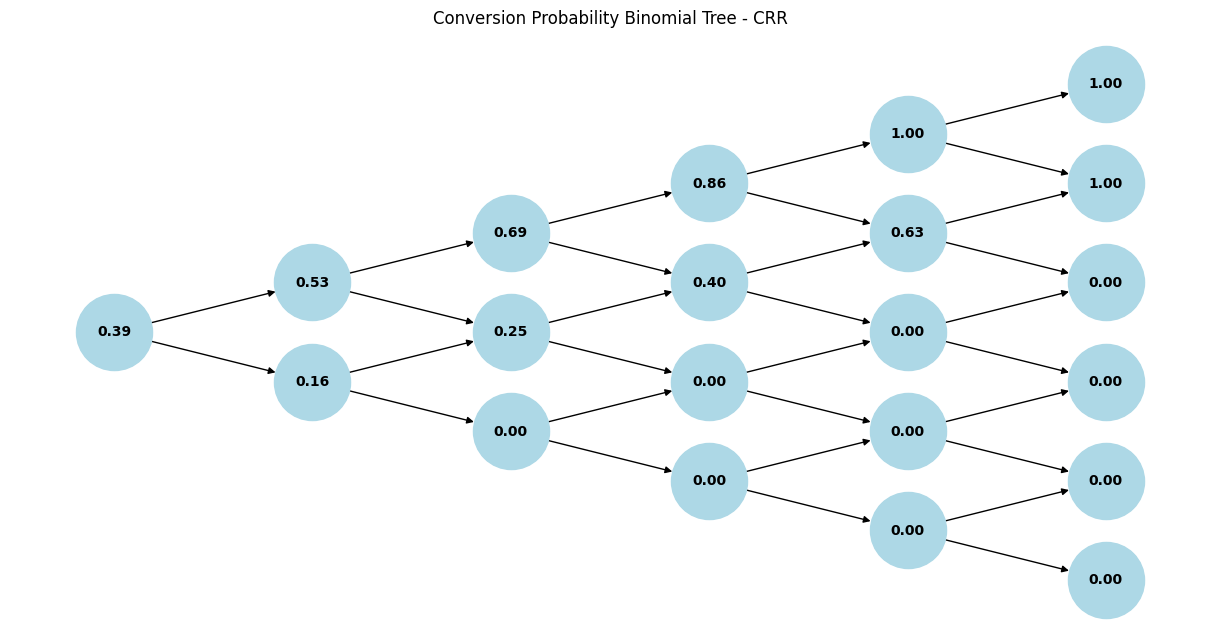


=== Model: Jarrow-Rudd ===
u = 1.2840, d = 0.8607, p = 0.5000


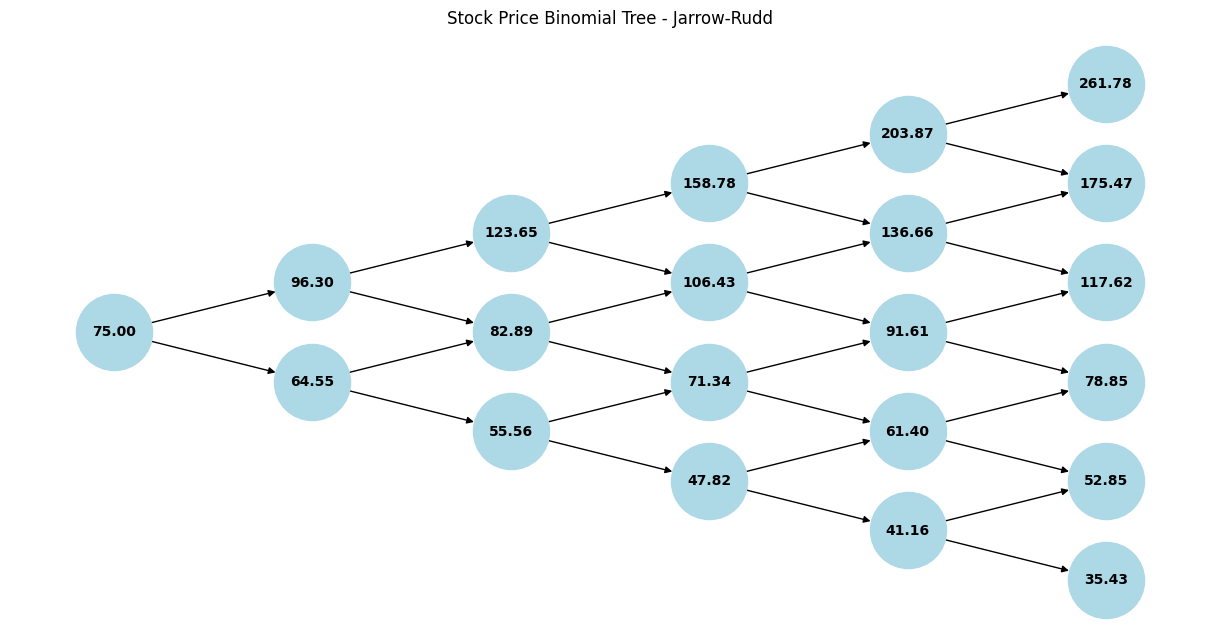

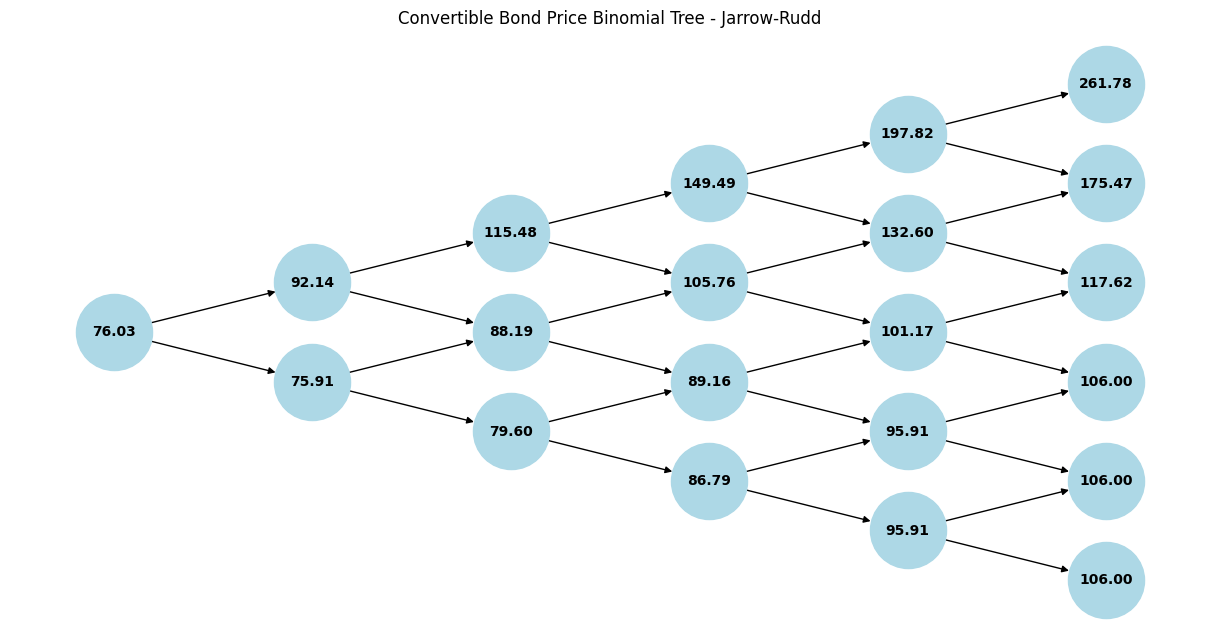

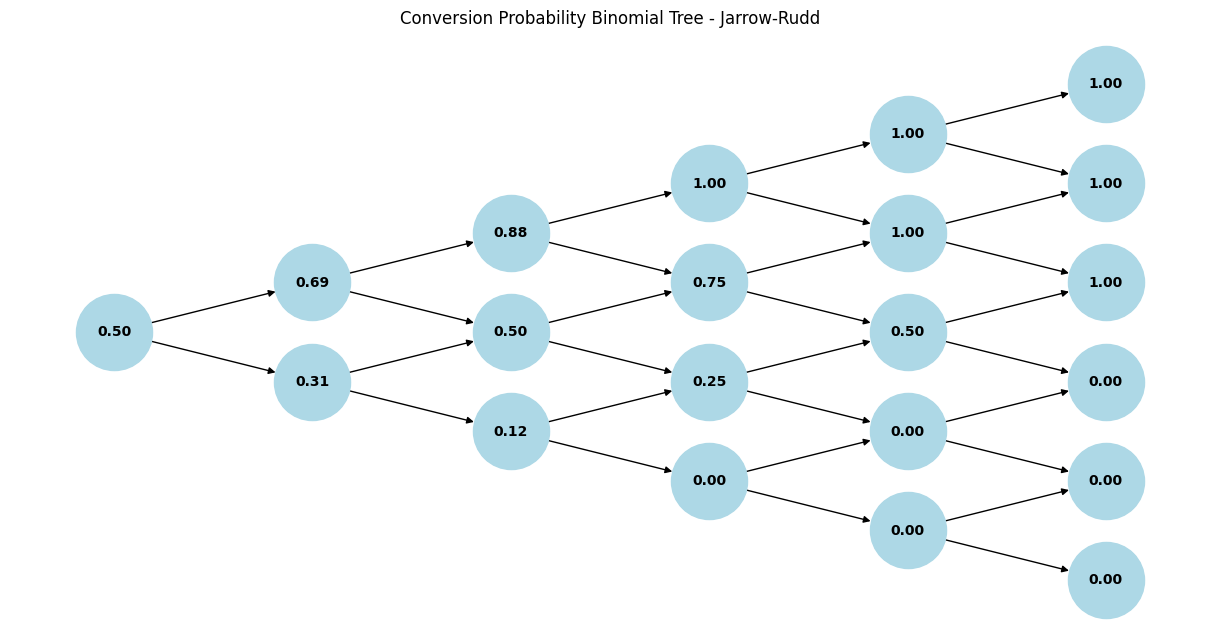


=== Model: Tian ===
u = 2.1881, d = 0.4902, p = 0.3430


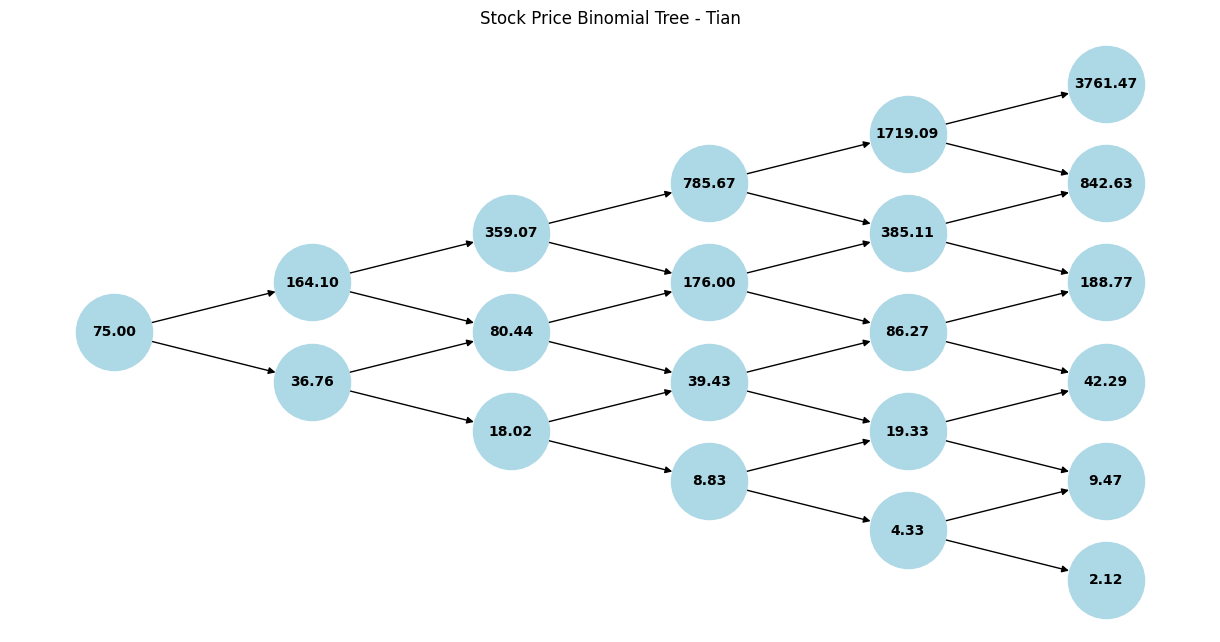

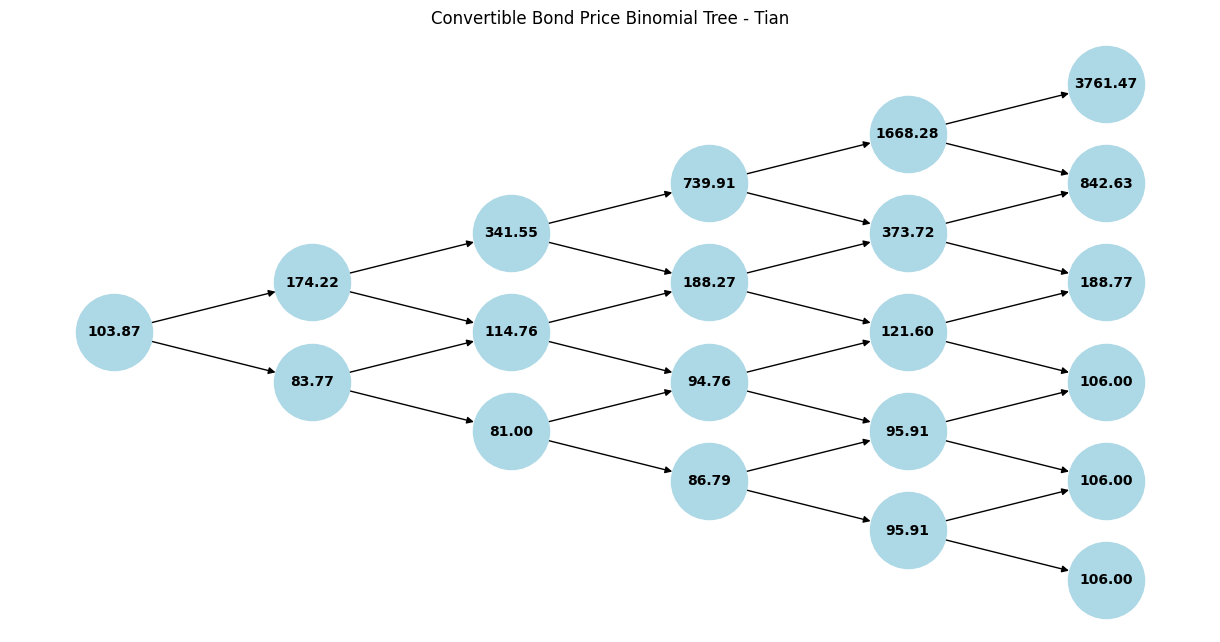

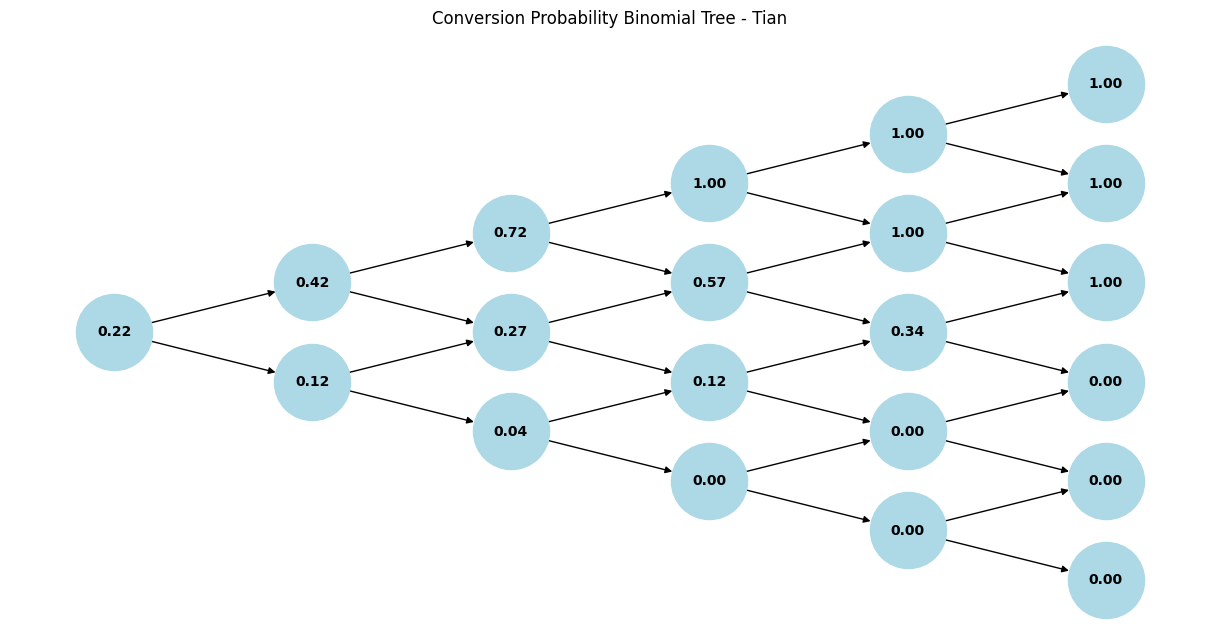


=== Model: CRR_Drift ===
u = 1.2214, d = 0.8187, p = 0.6302


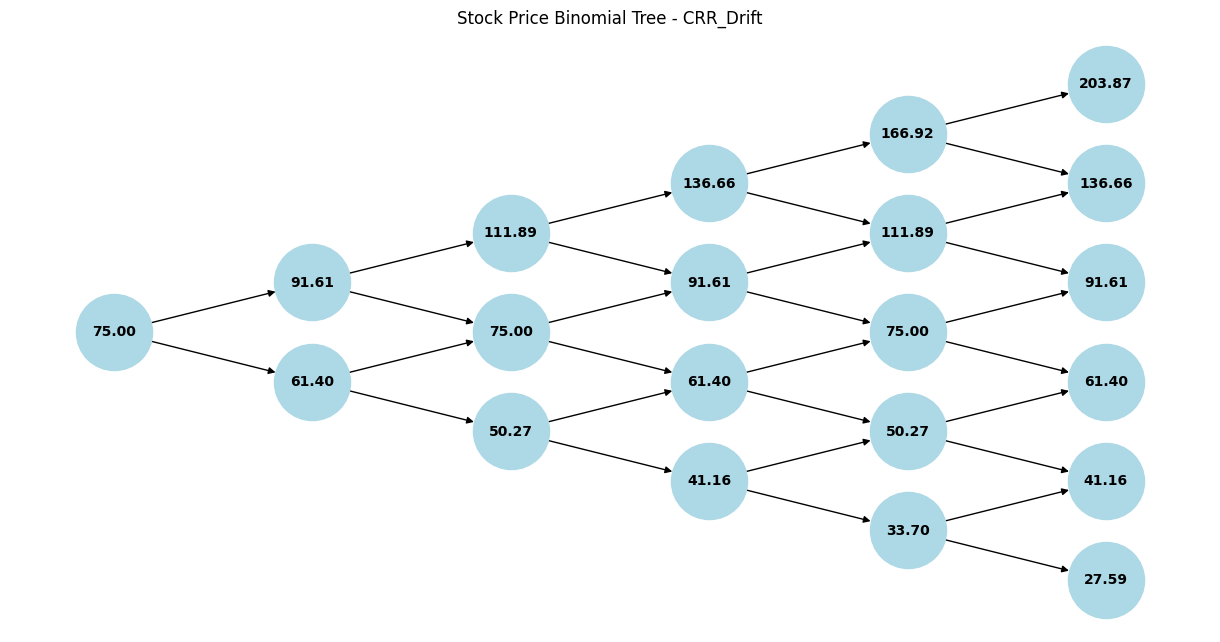

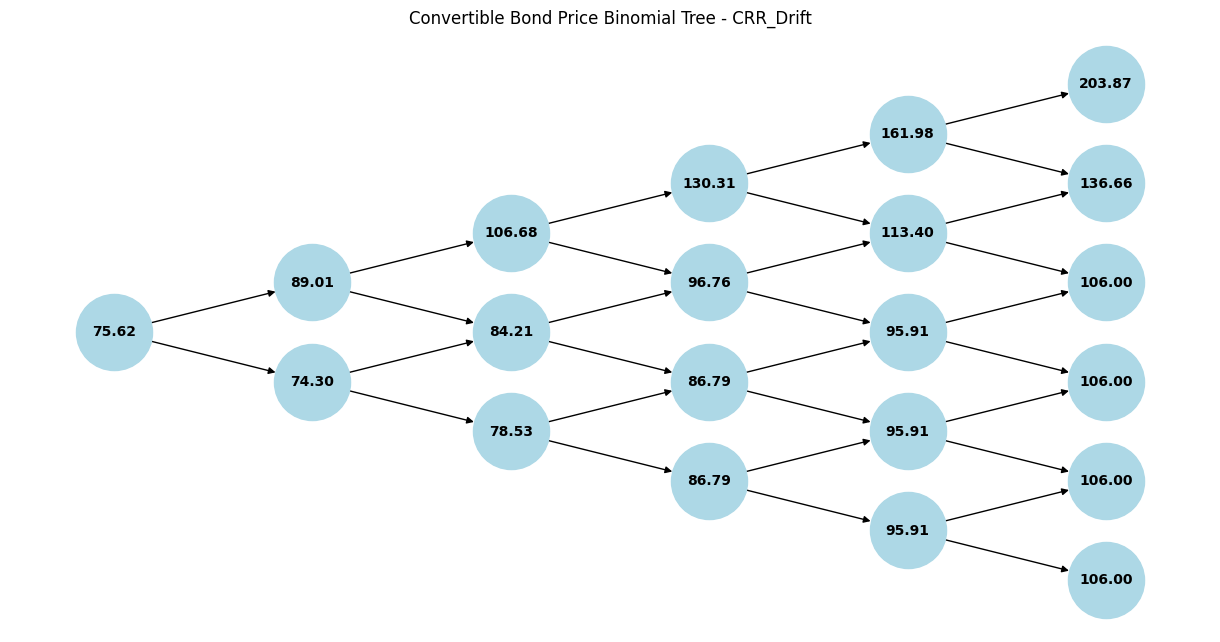

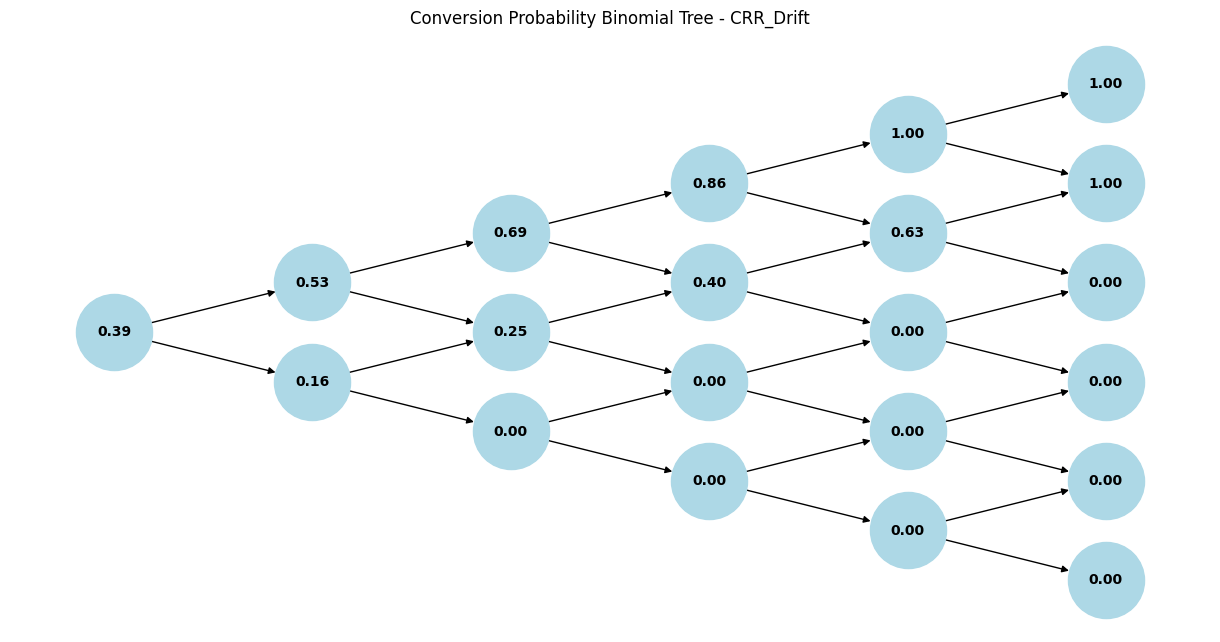


=== Model: Haahtela ===
u = 1.4140, d = 0.7072, p = 0.4868


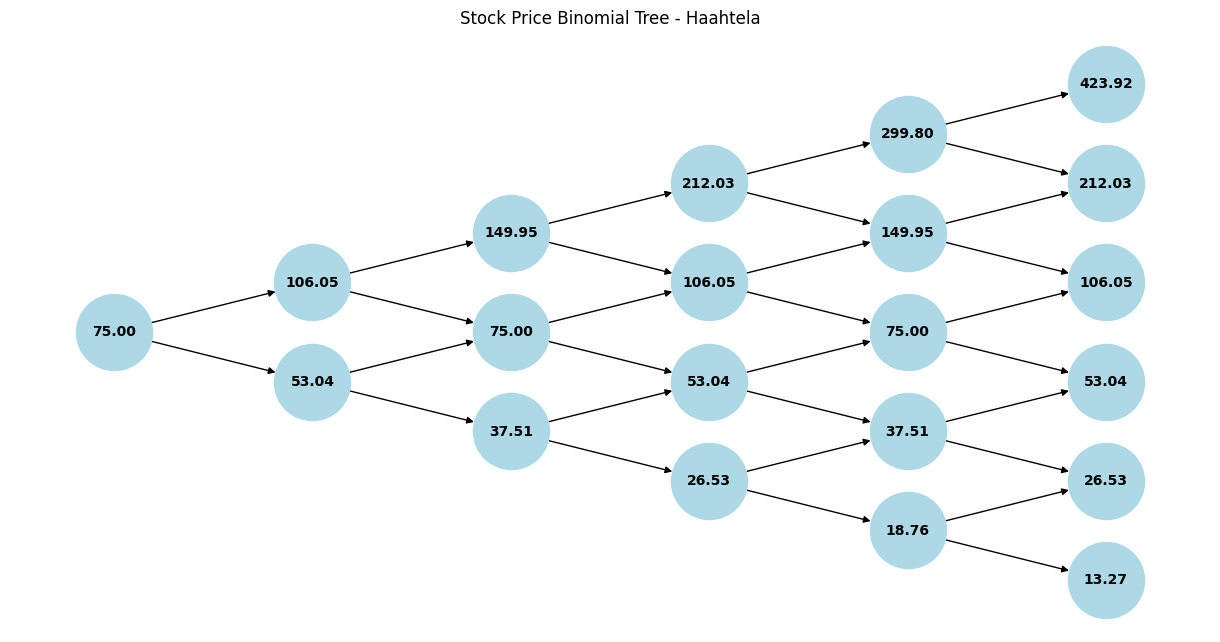

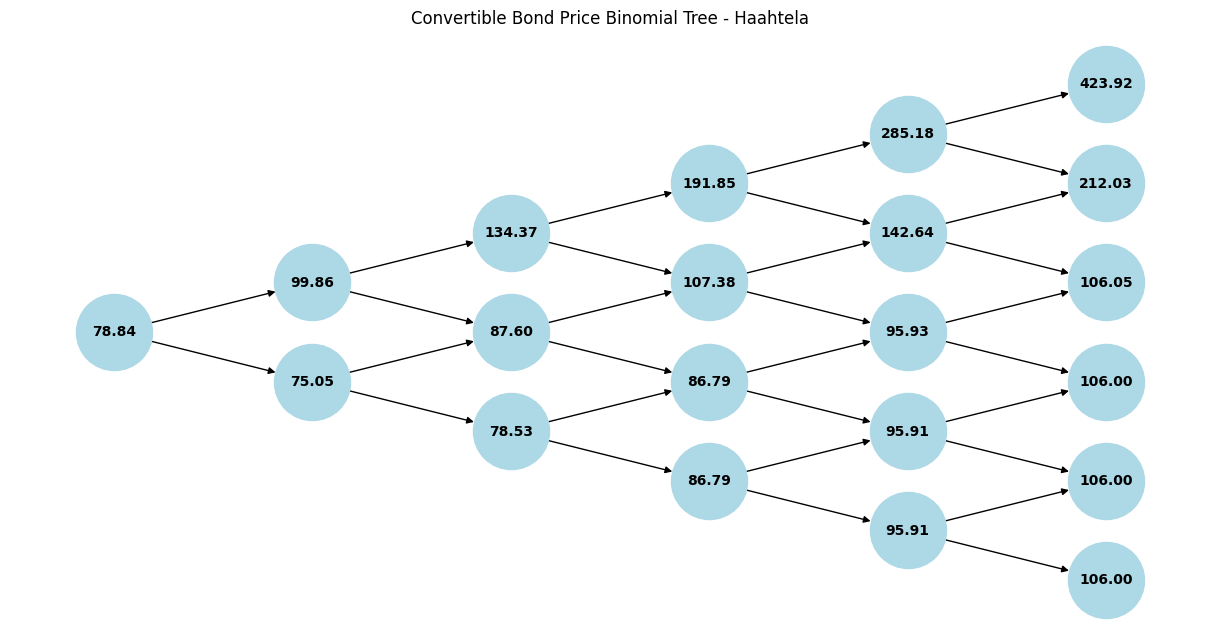

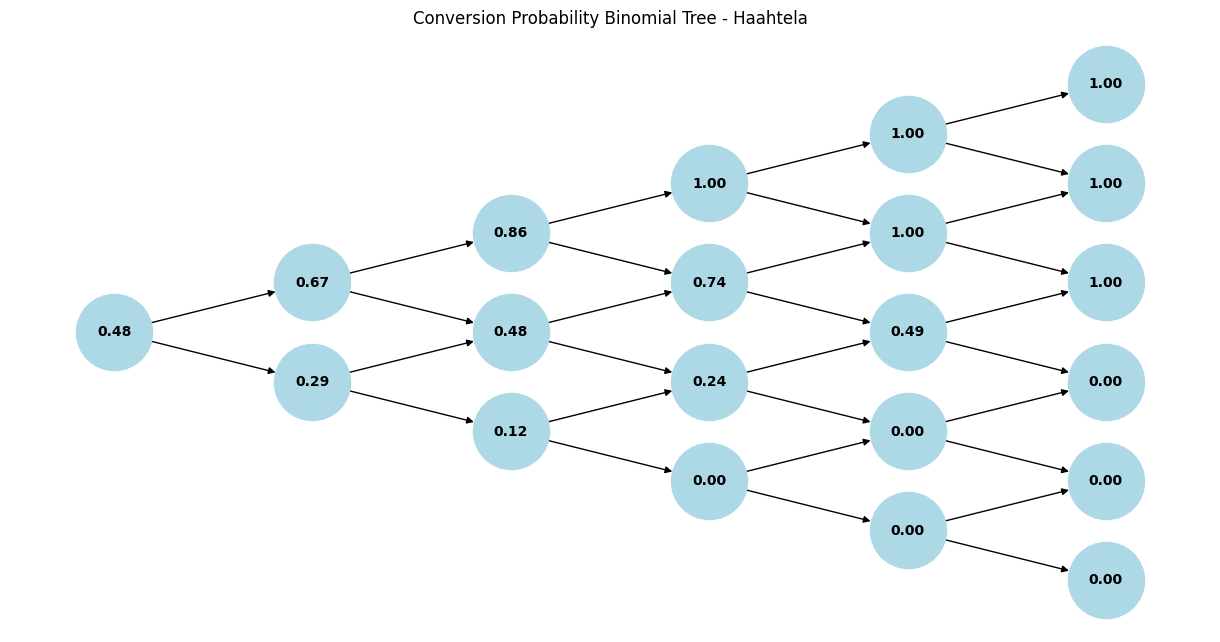

In [10]:
# Input parameters
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
X = 100           # Strike price for conversion
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
CRatio = F / X    # Conversion ratio 
N = 5         # Number of steps in the tree

# Define models to be plotted
models = ['CRR', 'Jarrow-Rudd', 'Tian', 'CRR_Drift', 'Haahtela']

# Generate and plot the trees
create_and_plot_trees(S0, F, T, r, k, sigma, q, coupon, CRatio, N, models)

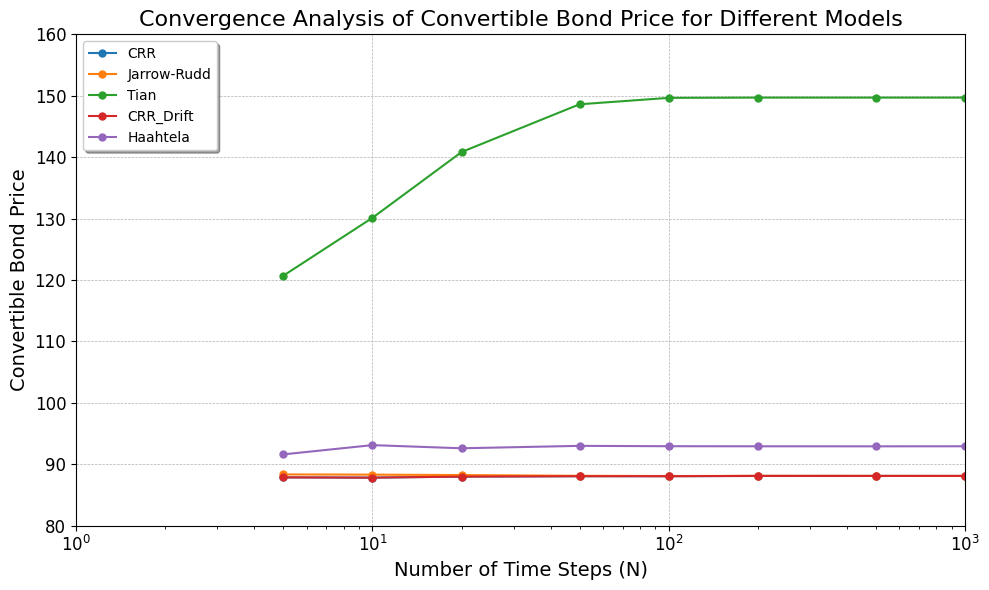

In [11]:
""" import numpy as np
import matplotlib.pyplot as plt

# Function to calculate tree parameters (u, d, p) for different models
def calculate_tree_parameters(r, q, sigma, dt, model_type, drift=0):
    if model_type == 'CRR':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r - q) * dt) - d) / (u - d)
    elif model_type == 'CRR_Drift':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r - q + drift) * dt) - d) / (u - d)
    elif model_type == 'Jarrow-Rudd':
        u = np.exp((r - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt))
        d = np.exp((r - q - 0.5 * sigma ** 2) * dt - sigma * np.sqrt(dt))
        p = 0.5
    elif model_type == 'Tian':
        a = np.exp((r - q) * dt)
        b = np.exp(sigma * np.sqrt(dt))
        u = 0.5 * a * (b + 1 / b + np.sqrt((b - 1 / b) ** 2 + 4))
        d = a / u
        p = (a - d) / (u - d)
    elif model_type == 'Haahtela':
        b = r - q - 0.5 * sigma**2
        u = np.exp(sigma * np.sqrt(3 * dt))
        d = 1 / u
        p = (np.exp(b * dt) - d) / (u - d)  
    else:
        raise ValueError("Unknown model type provided.")
    return u, d, p

# Function to calculate the bond price using the binomial tree method
def convertible_bond_price(S0, F, T, r, sigma, q, coupon, CRatio, N, model_type, drift=0):
    dt = T / N
    u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift)

    # Create stock price tree
    StockPrice = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create bond price tree
    BondPrice = np.zeros((N + 1, N + 1))
    # Calculate bond price at maturity
    for i in range(N + 1):
        BondPrice[i, N] = max(F + coupon, CRatio * StockPrice[i, N])

    # Backward induction
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            # Calculate the present value of the bond price
            BondPrice[i, j] = np.exp(-r * dt) * (p * BondPrice[i + 1, j + 1] + (1 - p) * BondPrice[i, j + 1])

    return BondPrice[0, 0]

# Parameters for the bond
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
CRatio = F / 100  # Conversion ratio 

# Use a range of N for convergence analysis
N_steps = np.array([5, 10, 20, 50, 100, 200, 500, 1000])  # Different time steps for convergence

# Define models to be analyzed
models = ['CRR', 'Jarrow-Rudd', 'Tian', 'CRR_Drift', 'Haahtela']
convergence_results = {model: [] for model in models}

# Perform convergence analysis for each model
for model in models:
    for N in N_steps:
        price = convertible_bond_price(S0, F, T, r, sigma, q, coupon, CRatio, N, model)
        convergence_results[model].append(price)

# Plot convergence results with the requested format
fig, ax = plt.subplots(figsize=(10, 6))

# Configure plot to closely match the layout of Fig. 4.6
for model in models:
    ax.plot(N_steps, convergence_results[model], label=model, marker='o', linestyle='-', markersize=5)

# Customize the plot to match Figure 4.6 style
ax.set_xlabel('Number of Time Steps (N)', fontsize=14)
ax.set_ylabel('Convertible Bond Price', fontsize=14)
ax.set_title('Convergence Analysis of Convertible Bond Price for Different Models', fontsize=16)
ax.legend(title="Models", fontsize=12, loc='upper right')
ax.grid(True, linestyle='--', linewidth=0.5)
ax.set_xscale('log')  # Use logarithmic scale for the x-axis as shown in Fig. 4.6
ax.set_xlim(1, 1000)  # Ensure the x-axis limits are consistent
ax.set_ylim(80, 160)  # Ensure y-axis limits are set for better visualization

# Final adjustments to resemble the figure
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()
 """

In [ ]:
def getPrice_LatticeModel(S0, F, T, r, sigma, q, coupon, conversion_ratio, steps, model_type, drift=0):
    dt = T / steps
    u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift)

    # Create the binomial stock price tree
    StockPrice = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price and conversion probability trees
    BondPrice = np.zeros((steps + 1, steps + 1))
    ConversionProbability = np.zeros((steps + 1, steps + 1))

    # Calculate bond value at maturity
    for i in range(steps + 1):
        BondPrice[i, steps] = max(F + coupon, conversion_ratio * StockPrice[i, steps])
        ConversionProbability[i, steps] = 1 if BondPrice[i, steps] == conversion_ratio * StockPrice[i, steps] else 0

    # Backward calculation for bond price and conversion probability
    for j in range(steps - 1, -1, -1):
        for i in range(j + 1):
            # Calculate the present value of the bond price using risk-neutral probabilities
            BondPrice[i, j] = np.exp(-r * dt) * (p * BondPrice[i + 1, j + 1] + (1 - p) * BondPrice[i, j + 1])

            # Calculate conversion probability as weighted average
            ConversionProbability[i, j] = p * ConversionProbability[i + 1, j + 1] + (1 - p) * ConversionProbability[i, j + 1]

    return  BondPrice[0,0]

In [ ]:
# Input parameters
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
X = 100           # Strike price for conversion
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
CRatio = F / X    # Conversion ratio
min_step = 2
max_step = 700       # Number of steps in the tree
model_type='CRR'

UROBORO = np.zeros([max_step-min_step])
j=0
for i in np.arange(min_step,max_step):
  UROBORO[j]=getPrice_LatticeModel(S0, F, T, r, sigma, q, coupon, CRatio, i, model_type, drift=0)
  j=j+1

plt.plot(UROBORO) #una bella chopped convergence


In [ ]:
np.zeros([max_step])